# Explainable Global kNN Outlier Detection

The idea is to use a global kNN approach on synthetically generated data for outlier detection. To keep it simple and beeing able to visualize it, only two dimensions are used. Here three different data structures are beeing evaluted:
- Single Multidimensional Normal Distribution
- Multiple Clusters
- Multiple Multidimensional Normal Distributions

Afterwards the the learned representation of the data shall be used to derive a explanation why a certain point is scored as an outler and which dimension may caused this. Here the following two appraoches are beeing evaluated:
- Mean distance per dimension to k nearest Neighbors

In [63]:
from sklearn.neighbors import NearestNeighbors
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


sns.set_style('darkgrid')

SEED = 42

np.random.seed(SEED)

## Single Multidimensional Normal Distribution

### Generate Synthetic Data
This creates synthetic data based on a two dimensional normal distribution and introduces outliers in x, y or in both dimensions.

In [64]:
mean = [0, 0]
covariance = [[1, 0.7], [0.7, 1]]
pdf = stats.multivariate_normal(mean, covariance)
samples_size = 500
samples = pdf.rvs(size=samples_size)
samples.shape

(500, 2)

In [65]:
def get_uniform_rand(lower, upper, size):
    rand = np.zeros(size)
    for i in range(size):
        b = np.random.choice(a=[False, True])
        if b:
            rand[i] = np.random.uniform(lower, upper, 1)
        else:
            rand[i] = np.random.uniform(lower * -1, upper * -1, 1)
    return rand

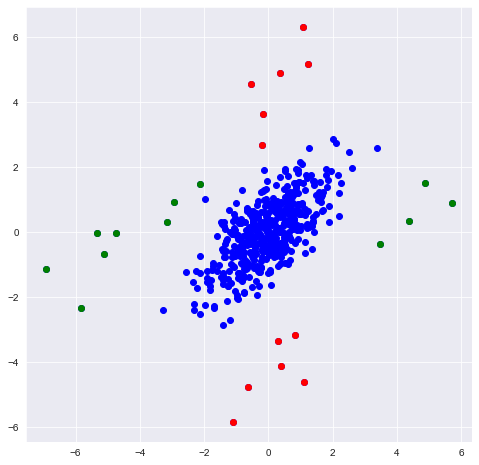

In [66]:
anomalies_fac = 0.05


def make_outliers(samples, anomalies_fac):
    samples_size = len(samples)
    anomalies_size = int(samples_size * anomalies_fac)
    rand_idx = np.random.randint(0, samples_size, anomalies_size)
    rand_idx_y = rand_idx[0: int(anomalies_size / 2)]
    rand_idx_x = rand_idx[int(anomalies_size / 2): -1]
    samples[rand_idx_y, 1] = samples[rand_idx_y, 1] + get_uniform_rand(3, 5, len(rand_idx_y))
    samples[rand_idx_x, 0] = samples[rand_idx_x, 0] + get_uniform_rand(3, 5, len(rand_idx_x))
    return samples, (rand_idx, rand_idx_x, rand_idx_y)

samples, (rand_idx, rand_idx_x, rand_idx_y) = make_outliers(samples, anomalies_fac)

plt.figure(figsize=(8,8))
plt.scatter(x = samples[:, 0], y = samples[:, 1], c="b")
plt.scatter(x = samples[rand_idx_y, 0], y = samples[rand_idx_y, 1], c="r")
plt.scatter(x = samples[rand_idx_x, 0], y = samples[rand_idx_x, 1], c="g")
#plt.xlim([-10, 10])
#plt.ylim([-10, 10])



### Fit global kNN
This fits a global kNN to the data and estimates the outliers by giving the outlier score as the mean eucledian distance to the k nearest neighbors. <br>
Also it plots the ROC Curve to get and overview how well the model predicts the outlers. 

In [67]:
min_max_scaler = MinMaxScaler()
samples_scaled = min_max_scaler.fit_transform(samples)

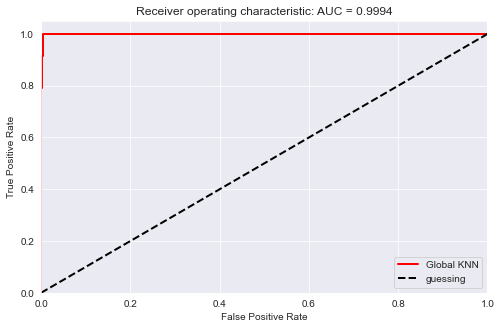

,f1,f2,score,label
369,-6.921023,-1.142628,0.313116,1.0
304,1.060484,6.314499,0.295268,1.0
427,-1.088591,-5.852330,0.262855,1.0
415,5.706042,0.883730,0.259351,1.0
327,-5.836578,-2.349585,0.257563,1.0


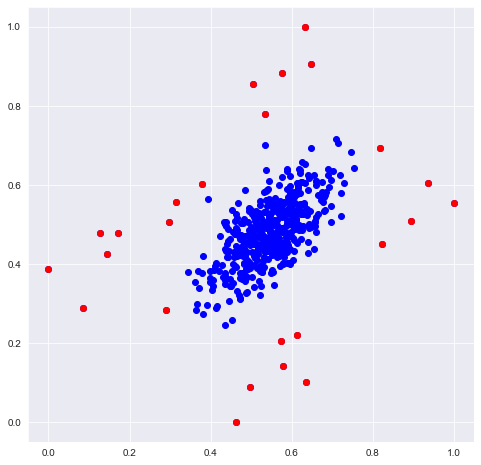

In [68]:
N_NEIGHBORS = 20
ALGORITHM = "brute"

neigh = NearestNeighbors(n_neighbors=N_NEIGHBORS+1, algorithm=ALGORITHM)
neigh.fit(samples_scaled)
# calculate the n nearest neighbors for the given dataset
knn_scores, neighbors = neigh.kneighbors(samples_scaled, N_NEIGHBORS+1, return_distance=True)
# calculate the global knn gy caluclating the avg and exluding the first one
scores = [sum(scores)/len(scores-1) for scores in knn_scores]

scored_df = pd.DataFrame(samples)
scored_df.reset_index()
scored_df.columns = ["f1", "f2"]
scored_df["score"] = scores
labels = np.zeros(samples_size)
labels[rand_idx] = 1
scored_df["label"] = labels


fpr, tpr, thresholds = metrics.roc_curve(scored_df['label'], scored_df['score'], pos_label=1)
auc = metrics.auc(fpr,tpr)

plt.figure(figsize=[8,5])
plt.plot(fpr, tpr, color='r', lw=2, label='Global KNN')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: AUC = {0:0.4f}'.format(auc))
plt.legend(loc="lower right")
plt.show()


sorted_df = scored_df.sort_values(by="score", ascending=False)

plt.figure(figsize=(8,8))
plt.scatter(x = samples_scaled[:, 0], y = samples_scaled[:, 1], c="b")
detected_outliers_idx = sorted_df[["f1", "f2"]].head(len(rand_idx)).index
plt.scatter(x = samples_scaled[detected_outliers_idx][:, 0], y = samples_scaled[detected_outliers_idx][:, 1], c="r")


sorted_df.head(5)

Seems like the global kNN detected nearly all outliers. 

### Outlier Explainability

The idea is now to use the k nearset neihgbors to derive an explanation why certain points are detected as outliers. This is done by calculating the eucledian distance oper dimension. 



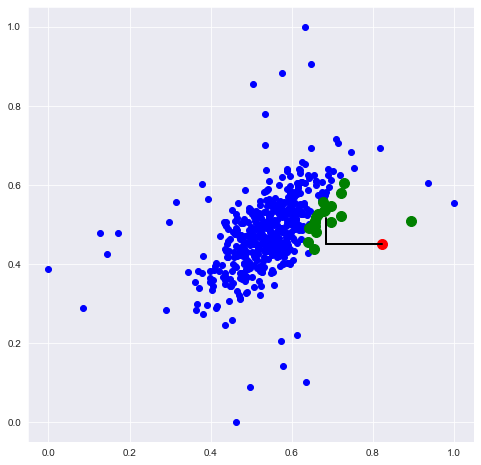

In [72]:
TOP_X_OUTLIER = 0
#TOP_X_OUTLIER = 1
TOP_X_OUTLIER = 16

top_anomalies_idx = sorted_df.index.values
anomaly_idx = top_anomalies_idx[TOP_X_OUTLIER]
d = samples_scaled[anomaly_idx]
n = neighbors[:, 1:][anomaly_idx]
mean_dist_x = np.mean([d[0] - x[0] for x in samples_scaled[n]])
mean_dist_y = np.mean([d[1] - x[1] for x in samples_scaled[n]])

plt.figure(figsize=(8,8))
plt.scatter(x = samples_scaled[:, 0], y = samples_scaled[:, 1], c="b")
plt.scatter(x = d[0], y = d[1], c="r", s=100)
plt.scatter(x = samples_scaled[n][:, 0], y = samples_scaled[n][:, 1], c="g", s=100)

plt.plot([d[0], d[0] - mean_dist_x], [d[1], d[1]], 'k-', lw=2)
plt.plot([d[0] - mean_dist_x, d[0] - mean_dist_x], [d[1], d[1] - mean_dist_y], 'k-', lw=2)

# Blobs Clusters

In [73]:
from sklearn.datasets import make_blobs

In [74]:
X, y = make_blobs(n_samples=[200, 200, 100], centers=None, center_box=(-5, 5), random_state=SEED, cluster_std=[0.8, 0.6, 0.3])
samples = X
samples.shape

(500, 2)

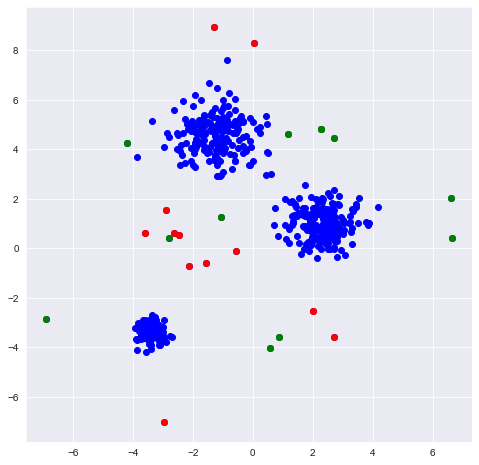

In [75]:
anomalies_fac = 0.05

samples, (rand_idx, rand_idx_x, rand_idx_y) = make_outliers(samples, anomalies_fac)

plt.figure(figsize=(8,8))
plt.scatter(x = samples[:, 0], y = samples[:, 1], c="b")
plt.scatter(x = samples[rand_idx_y, 0], y = samples[rand_idx_y, 1], c="r")
plt.scatter(x = samples[rand_idx_x, 0], y = samples[rand_idx_x, 1], c="g")
#plt.xlim([-10, 10])
#plt.ylim([-10, 10])

In [76]:
min_max_scaler = MinMaxScaler()
samples_scaled = min_max_scaler.fit_transform(samples)

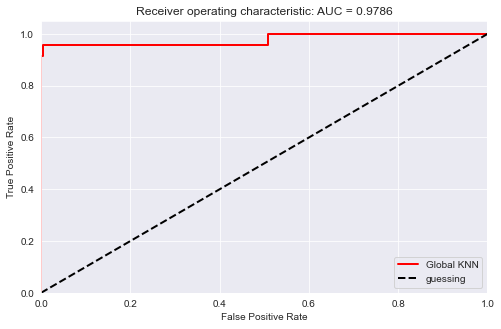

,f1,f2,score,label
95,0.585161,-4.006917,0.227528,1.0
227,6.634875,0.399561,0.225737,1.0
65,6.593236,2.037947,0.224125,1.0
353,-6.892630,-2.836993,0.224024,1.0
104,0.878092,-3.590671,0.208336,1.0


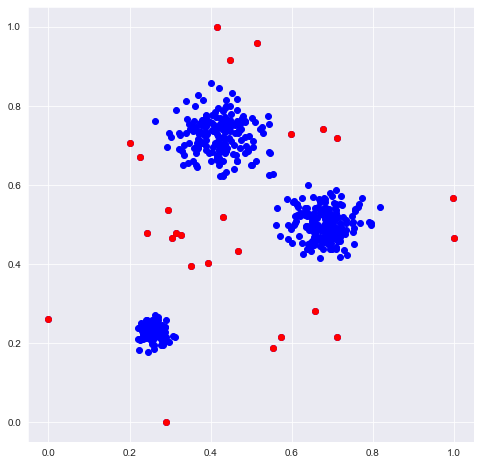

In [77]:
N_NEIGHBORS = 20
ALGORITHM = "brute"

neigh = NearestNeighbors(n_neighbors=N_NEIGHBORS+1, algorithm=ALGORITHM)
neigh.fit(samples_scaled)
# calculate the n nearest neighbors for the given dataset
knn_scores, neighbors = neigh.kneighbors(samples_scaled, N_NEIGHBORS+1, return_distance=True)
# calculate the global knn gy caluclating the avg and exluding the first one
scores = [sum(scores)/len(scores-1) for scores in knn_scores]

scored_df = pd.DataFrame(samples)
scored_df.reset_index()
scored_df.columns = ["f1", "f2"]
scored_df["score"] = scores
labels = np.zeros(samples_size)
labels[rand_idx] = 1
scored_df["label"] = labels


fpr, tpr, thresholds = metrics.roc_curve(scored_df['label'], scored_df['score'], pos_label=1)
auc = metrics.auc(fpr,tpr)

plt.figure(figsize=[8,5])
plt.plot(fpr, tpr, color='r', lw=2, label='Global KNN')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: AUC = {0:0.4f}'.format(auc))
plt.legend(loc="lower right")
plt.show()


sorted_df = scored_df.sort_values(by="score", ascending=False)

plt.figure(figsize=(8,8))
plt.scatter(x = samples_scaled[:, 0], y = samples_scaled[:, 1], c="b")
detected_outliers_idx = sorted_df[["f1", "f2"]].head(len(rand_idx)).index
plt.scatter(x = samples_scaled[detected_outliers_idx][:, 0], y = samples_scaled[detected_outliers_idx][:, 1], c="r")

sorted_df.head(5)

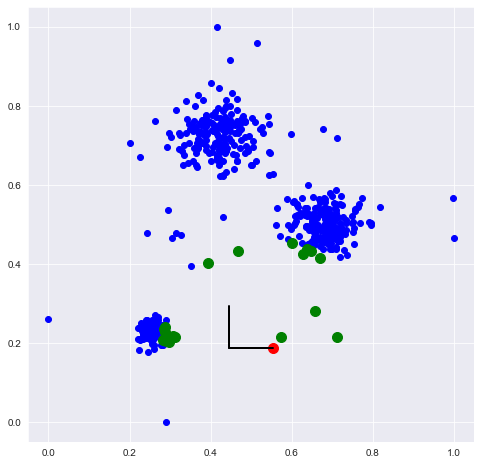

In [82]:
TOP_X_OUTLIER = 0
#TOP_X_OUTLIER = 1
#TOP_X_OUTLIER = 8

top_anomalies_idx = sorted_df.index.values
anomaly_idx = top_anomalies_idx[TOP_X_OUTLIER]
d = samples_scaled[anomaly_idx]
n = neighbors[:, 1:][anomaly_idx]
mean_dist_x = np.mean([d[0] - x[0] for x in samples_scaled[n]])
mean_dist_y = np.mean([d[1] - x[1] for x in samples_scaled[n]])

plt.figure(figsize=(8,8))
plt.scatter(x = samples_scaled[:, 0], y = samples_scaled[:, 1], c="b")
plt.scatter(x = d[0], y = d[1], c="r", s=100)
plt.scatter(x = samples_scaled[n][:, 0], y = samples_scaled[n][:, 1], c="g", s=100)

plt.plot([d[0], d[0] - mean_dist_x], [d[1], d[1]], 'k-', lw=2)
plt.plot([d[0] - mean_dist_x, d[0] - mean_dist_x], [d[1], d[1] - mean_dist_y], 'k-', lw=2)

# Miltiple Guassian

In [83]:
X, y = make_blobs(n_samples=samples_size, random_state=SEED)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
samples = X_aniso
samples.shape

(500, 2)

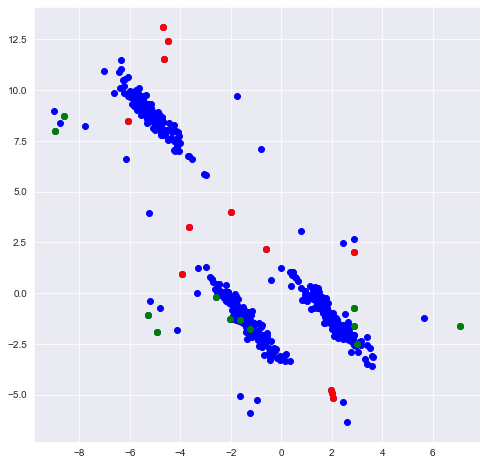

In [85]:
anomalies_fac = 0.05

samples, (rand_idx, rand_idx_x, rand_idx_y) = make_outliers(samples, anomalies_fac)

plt.figure(figsize=(8,8))
plt.scatter(x = samples[:, 0], y = samples[:, 1], c="b")
plt.scatter(x = samples[rand_idx_y, 0], y = samples[rand_idx_y, 1], c="r")
plt.scatter(x = samples[rand_idx_x, 0], y = samples[rand_idx_x, 1], c="g")
#plt.xlim([-10, 10])
#plt.ylim([-10, 10])

In [86]:
min_max_scaler = MinMaxScaler()
samples_scaled = min_max_scaler.fit_transform(samples)

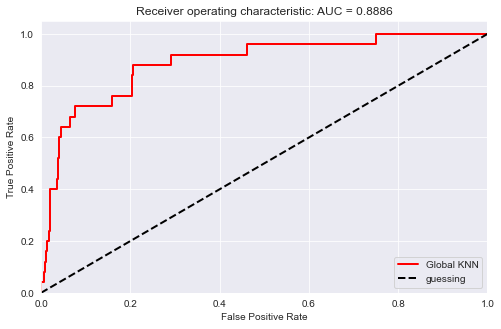

,f1,f2,score,label
426,7.080012,-1.630457,0.229620,1.0
484,-0.796139,7.100344,0.183747,0.0
106,-1.747764,9.689808,0.173681,0.0
92,-5.229168,3.938436,0.165689,0.0
368,-8.952650,8.006492,0.159603,1.0


In [87]:
N_NEIGHBORS = 20
ALGORITHM = "brute"

neigh = NearestNeighbors(n_neighbors=N_NEIGHBORS+1, algorithm=ALGORITHM)
neigh.fit(samples_scaled)
# calculate the n nearest neighbors for the given dataset
knn_scores, neighbors = neigh.kneighbors(samples_scaled, N_NEIGHBORS+1, return_distance=True)
# calculate the global knn gy caluclating the avg and exluding the first one
scores = [sum(scores)/len(scores-1) for scores in knn_scores]

scored_df = pd.DataFrame(samples)
scored_df.reset_index()
scored_df.columns = ["f1", "f2"]
scored_df["score"] = scores
labels = np.zeros(samples_size)
labels[rand_idx] = 1
scored_df["label"] = labels


fpr, tpr, thresholds = metrics.roc_curve(scored_df['label'], scored_df['score'], pos_label=1)
auc = metrics.auc(fpr,tpr)

plt.figure(figsize=[8,5])
plt.plot(fpr, tpr, color='r', lw=2, label='Global KNN')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: AUC = {0:0.4f}'.format(auc))
plt.legend(loc="lower right")
plt.show()


sorted_df = scored_df.sort_values(by="score", ascending=False)
sorted_df.head(5)

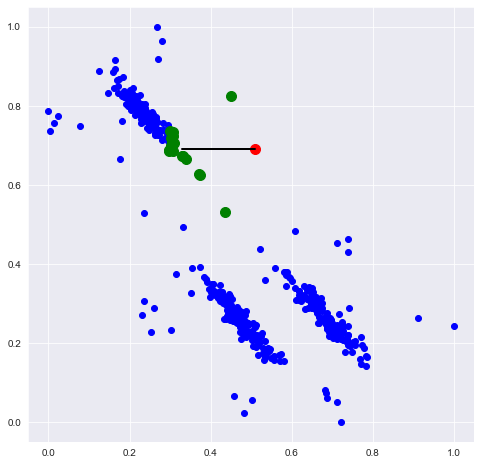

In [89]:
TOP_X_OUTLIER = 0
TOP_X_OUTLIER = 1
#TOP_X_OUTLIER = 5

top_anomalies_idx = sorted_df.index.values
anomaly_idx = top_anomalies_idx[TOP_X_OUTLIER]
d = samples_scaled[anomaly_idx]
n = neighbors[:, 1:][anomaly_idx]
mean_dist_x = np.mean([d[0] - x[0] for x in samples_scaled[n]])
mean_dist_y = np.mean([d[1] - x[1] for x in samples_scaled[n]])

plt.figure(figsize=(8,8))
plt.scatter(x = samples_scaled[:, 0], y = samples_scaled[:, 1], c="b")
plt.scatter(x = d[0], y = d[1], c="r", s=100)
plt.scatter(x = samples_scaled[n][:, 0], y = samples_scaled[n][:, 1], c="g", s=100)

plt.plot([d[0], d[0] - mean_dist_x], [d[1], d[1]], 'k-', lw=2)
plt.plot([d[0] - mean_dist_x, d[0] - mean_dist_x], [d[1], d[1] - mean_dist_y], 'k-', lw=2)